In [ ]:
import sys,os
sys.path.append("/home/edo/Software/TESI/AstroCosmoComputational/Students/Martinelli_Edoardo/")
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from numpy.linalg import inv
from numpy.linalg import multi_dot
import numpy as np
import matplotlib.pyplot as plt
from pylab import figure, cm
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",})
# Import distances class
from pyACC.cosmology import *
# Import integration class
from pyACC.Calculus import *
import scipy as sp
# Import the plotting module
from getdist import plots, MCSamples
import getdist

In [ ]:
# reading of data and covariance matrix

h = open('SNIa_covariance.txt', 'r')
lines=h.readlines()
lines=np.array(lines)
n=lines.size
Cov=np.zeros((n,n))
Cov=np.loadtxt("SNIa_covariance.txt")
Cov_in=inv(Cov) # this is the inverse of cov matrix
det_cov=np.linalg.det(Cov)
h.close()
# Cov is a n x n npMatrix


# Now I read the data file
f = open('SNIa_data.txt', 'r')
lines=f.readlines()
lines=np.array(lines)
mu_Dl=np.zeros((n,2))
mu_Dl=np.loadtxt("SNIa_data.txt")
Mu_Dl=[]
for i in range(0,n):
    Mu_Dl.append(mu_Dl[i][1])
Mu_Dl=np.array(Mu_Dl)
Redz=[]
for i in range(0,n):
    Redz.append(mu_Dl[i][0])
Redz=np.array(Redz)
f.close()

# mu_Dl is a n x 2 matrix with the first coloumn as the magnitude and the second one the redshift
# Redz is a 1x n vector with redshifts


In [ ]:
c=299792 #km/s
def Hubble(z,H0,Om):
    return H0*np.sqrt(Om*(1+z)**3+(1-Om))
def chiz(z,H0,Om):
    chi=[]
    for i in range(0,z.size):
        Z=np.linspace(0,z[i],100)
        chi.append(np.trapz(c/Hubble(Z,H0,Om),Z))
    return np.array(chi)
def MU(z,H0,Om):
    return 5*np.log10((1+z)*chiz(z,H0,Om))-5

We have now to choose a posterior distribution of parameter, having data. We choose a gaussian Likelihood and its marginalized version on the intrinsic luminosity of supernovae.



In [ ]:
def logLH(w,OmM):
    x = (Mu_Dl-distance_modulus(Redz,wde=w,omegaM=OmM,omegaLam=1-OmM))
    #x = (Mu_Dl-MU(Redz,H0=h0,Om=OmM))
    return 0.5*(-multi_dot([x,Cov_in,x])+(multi_dot([np.ones(n),Cov_in,x]))**2/(multi_dot([np.ones(n),Cov_in,np.ones(n)])))
def LH(w,OmM):
    return np.exp(logLH(w,OmM))

def LH_not_marg(w,OmM):
    x = (Mu_Dl-distance_modulus(Redz,wde=w,omegaM=OmM,omegaLam=1-OmM))
    #x = (Mu_Dl-MU(Redz,H0=h0,Om=OmM))
    return np.abs(-0.5*multi_dot([x,Cov_in,x]))



In [ ]:
# LH is marginalized on the intrinsic luminosity of Supernovae
'''
likelihood =lambda h0,OmM: LH(h0,OmM)
L_H = Funct(likelihood)
ext_HO= 500
ext_OM= 50
ext_IN= np.array([1,0.01])
ext_SUP= np.array([ext_HO,ext_OM])
norm = L_H.Int(ext_IN,ext_SUP)
print(norm)
NORM_backup=2.654660696389643e-207
'''
'''
likelihood2= lambda h0,OmM: LH_not_marg(h0,OmM)
L_H2 = Funct(likelihood2)
ext_HO_NM= 500
ext_OM_NM= 50
ext_IN_NM= np.array([1,0.01])
ext_SUP_NM= np.array([ext_HO_NM,ext_OM_NM])
norm2 = L_H2.Int(ext_IN_NM,ext_SUP_NM)
print(norm2)
'''


In [ ]:
#NORM2_backup=-683248396.5482999
pdf= lambda w,OmM: logLH(w,OmM)
pdf_not_marg= lambda w,OmM: LH_not_marg(w,OmM)

In [ ]:
w_0=-1
Omm_0=0.3
X0=np.array([w_0,Omm_0])
Nint=500

In [18]:
Ds=np.array([0.01,0.01])
result_MH_lin,eff_MH_lin=Metropolis_Hastings(pdf,X0,Nint,Ds,type='flat',pdf_log=True)
H0_res_lin=result_MH_lin[:,0]
Omm_res_lin=result_MH_lin[:,1]

In [19]:
Ds_NM=np.array([0.01,0.01])
result_MH_NM,eff_MH_NM=Metropolis_Hastings(pdf_not_marg,X0,Nint,Ds_NM,type='flat',pdf_log=True)
H0_res_NM=result_MH_NM[:,0]
Omm_res_NM=result_MH_NM[:,1]

Function object created, you've inserted a  <class 'function'>  function with  2  variables


Removed no burn in


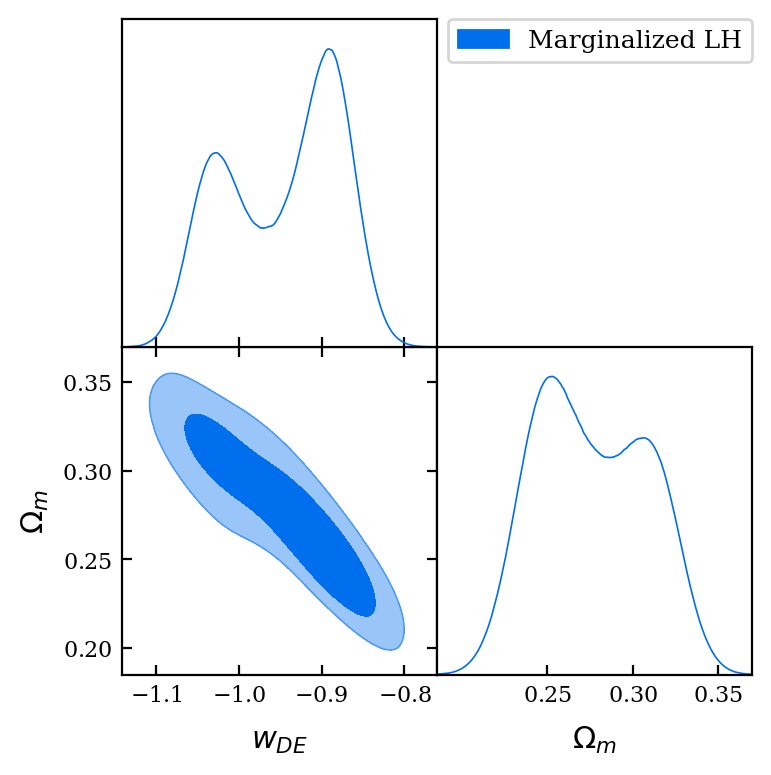

In [20]:
sam_lin=MCSamples(samples=result_MH_lin,names=['w','OmM'],labels=['w_{DE}','\Omega_m'],label='Marginalized on D0 LH')
#sam_NM=MCSamples(samples=result_MH_NM,names=['w','OmM'],labels=['w_{DE}','\Omega_m'],label='Not Marginalized on D0 LH')
g = plots.get_subplot_plotter()
g.triangle_plot(sam_lin, filled=True,legend_labels=['Marginalized LH'],legend_loc='upper right')
#g.triangle_plot([sam_lin,sam_NM], filled=True,legend_labels=['Marginalized LH','Not Marginalized on D0 LH'],legend_loc='upper right')